In [1]:
%matplotlib inline
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.table import Table
from scipy import interpolate

In [2]:
bands = ['VIS', 'Y', 'J', 'H']

# Compute the moments of each filter

In [3]:
def mean_trans(lbd, trans):
    """ Return the mean
    wavelength of the transmission
    """
    
    norm = np.trapz(trans, lbd)
    return np.trapz(trans*lbd, lbd)/norm

def std_trans(lbd, trans):
    """ Return the width
    in wavelength of 
    the filter
    """

    norm = np.trapz(trans, lbd)
    mean_lambda = mean_trans(lbd, trans)
    result = np.sqrt(
        np.trapz((
            mean_lambda-lbd)**2*trans, lbd)/norm)
    
    return result

def skewness_trans(lbd, trans):
    """ Return the skewness
    in wavelength of 
    the filter
    """
        
    norm = np.trapz(trans, lbd)
    mean_lambda = mean_trans(lbd, trans)
    sigma_lambda = std_trans(lbd, trans)

    result = np.trapz(
        ((mean_lambda-lbd)/sigma_lambda)**3*trans, lbd)/norm
    
    return result

In [4]:
wavelength = {}
transmissions = {}
reference_transmission = {}
reference_moments = {}

for band in bands:
    transmissions[band] = []
    reference_moments[band] = {}
    
    for i in range(1, 10):
        transmission = Table.read(f'EuclidBands/{band}_{i}.dat', format='ascii')
        transmissions[band].append(transmission['col2'])

    reference_transmission[band] = transmissions[band][7]
    wavelength[band] = transmission['col1']
    reference_moments[band]['mean'] = mean_trans(wavelength[band], reference_transmission[band])
    reference_moments[band]['std'] = std_trans(wavelength[band], reference_transmission[band])
    reference_moments[band]['skewness'] = skewness_trans(wavelength[band], reference_transmission[band])

# Reference transmissions

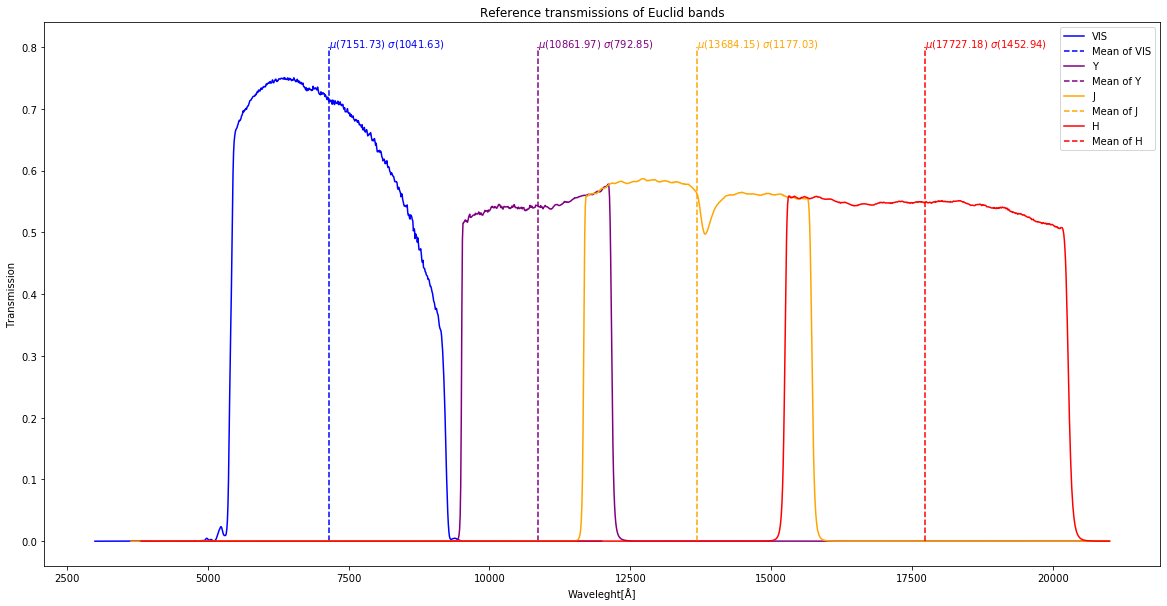

In [5]:
plt.figure(figsize=(20,10))
colors = itertools.cycle(['blue', 'purple', 'orange', 'red'])
for band in bands:
    c = next(colors)
    mean = reference_moments[band]['mean']
    std = reference_moments[band]['std']
    
    plt.plot(wavelength[band], reference_transmission[band], c=c, label=band)
    plt.plot([mean, mean], [0., .8], '--', c=c, label=f'Mean of {band}')
    plt.text(
        mean, .8,
        f'$\mu({mean:.2f})$ $\sigma({std:.2f})$', c=c
    )
plt.ylabel('Transmission')
plt.xlabel('Waveleght[Å]')
plt.title('Reference transmissions of Euclid bands')
plt.legend()
plt.show()

# Compute moment differences

In [6]:
moments_diff = {}
for band in bands:
    moments_diff[band] = {'mean': [], 'std': [], 'skewness X 100': []}
    for i in range(len(transmissions[band])):
        mean = mean_trans(wavelength[band], transmissions[band][i])
        std = std_trans(wavelength[band], transmissions[band][i])
        skewness = skewness_trans(wavelength[band], transmissions[band][i])
        moments_diff[band]['mean'].append(reference_moments[band]['mean'] - mean)
        moments_diff[band]['std'].append(reference_moments[band]['std'] - std)
        moments_diff[band]['skewness X 100'].append((reference_moments[band]['skewness'] - skewness)*100)

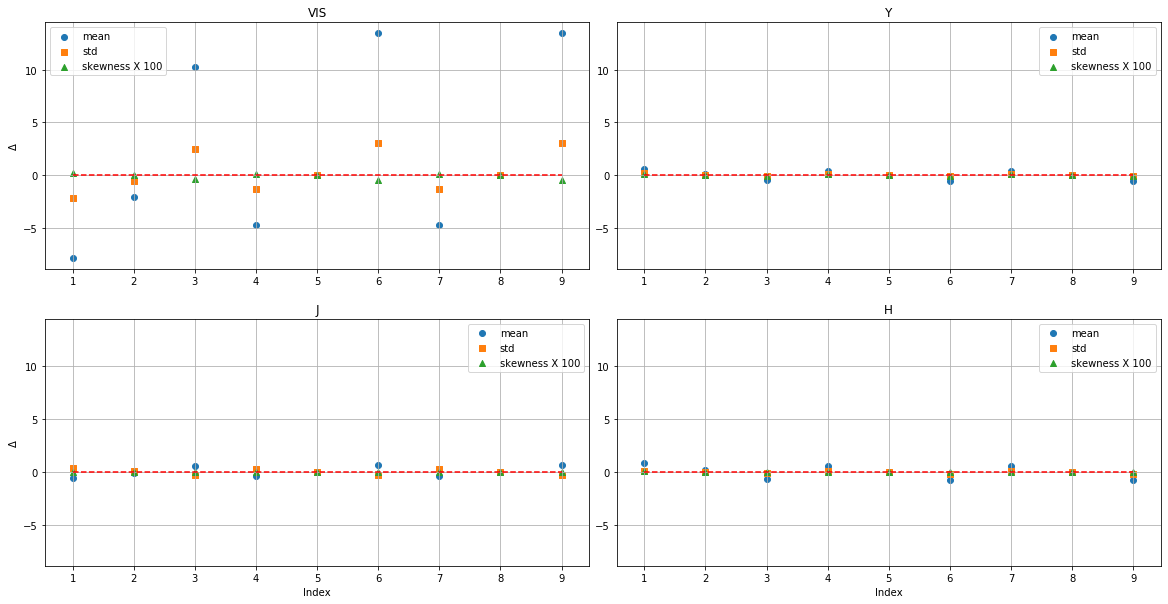

In [10]:
fig = plt.figure(figsize=(20, 10))
gs1 = gridspec.GridSpec(2, 2)
gs1.update(wspace=0.05, hspace=0.2)

ax = None
for i, band in enumerate(bands):
    ax = fig.add_subplot(gs1[i], sharey=ax)
    ax.plot([1, len(transmissions[band])], [0, 0], '--', c='red')
    markers = itertools.cycle(['o', 's', '^'])
    for k, v in moments_diff[band].items():
        ax.scatter(np.arange(1, len(transmissions[band])+1), moments_diff[band][k], marker=next(markers), label=k)
    ax.legend()
    ax.grid()
    ax.set_title(band)
    if i % 2 == 0:
        ax.set_ylabel('$\Delta$')
    if i // 2 == 1:
        ax.set_xlabel('Index')